# How to scrape all your eReceipts from your personal account in Woolworths Rewards/Everyday rewards

3 years ago I suggested a solution for how to fetch all your shopping data for Woolies using the eReceipt option they first offered. Some things changed since, but I still using it. If you wanna replicate my results, here's some code snippets and some explanations. 
It is a little exercise on scraping from passwod-protected website.

In [5]:
import requests as rq
import json
import base64

So modern Everyday Rewards app and the website use an graphQL-enabled API endpoint, access to which is conditioned on the same set of credentials as 3 years ago. You can experiment with their graphQL queries, but I put them here in the exactly same form they are used by Everyday Rewards App, so they just work. Follow me.

In [4]:
# endpoint url used by the website and their app
graphql_url = "https://apigee-prod.api-wr.com/wx/v1/bff/graphql" 

# This query get you the 'activity' feed in the App and in site - both point aquisition, some special messages, and eReceipts. Each record here is not necessarily contains an eReceipts. There may be a few records per one transaction also.
activity_query = "{\"variables\": {\"featureFlags\": { \"activityBreakdown\": true, \"activityBreakdownOnboarding\": true }, \"page\": \"FIRST_PAGE\", \"enableOnlineReceipt\": true     }, \"query\": \"query($page:String!$enableOnlineReceipt:Boolean$featureFlags:RewardsActivityFeedFeatureFlags!){rtlRewardsActivityFeed(pageToken:$page,featureFlags:$featureFlags){list{groups{...on RewardsActivityBanner{__typename id iconUrl title message messageCta action{url type}onDismissCoachMark{text anchor}analytics{label}}...on RewardsActivityFeedGroup{__typename id title items{id displayDate description message displayValue displayValueHandling icon iconUrl transaction{origin amountAsDollars}highlights{iconUrl description value style}receipt(enableOnlineReceipt:$enableOnlineReceipt){receiptId receiptSource}transactionType actionURL showChevron}}}nextPageToken}}}\"}"

# This query get you an individual receipt. You will need the RECEIPT_ID from the activity feed above. Interestingly, these ID are not constant for the Receipt (they change from scrape to scrape)
receipt_query = "{\"variables\": {\"id\":\"RECEIPT_ID\"},\"query\":\"query($id:String!){activityDetails(id:$id){__typename defaultTabSelection tabs{__typename navigationTitle navigationTitleAltText label page{...on ActivityBreakdown{__typename cards{...on ActivityBreakdownCardTotalPoints{__typename pointsTitle pointsSubtitle pointsIconUrl locationTitle locationIconUrl altText}...on ActivityBreakdownCardPoints{__typename pointsHeader{bonusPoints{value description note}basePoints{value description note}altText}pointsLineItems{title description iconUrl campaignCode altText altHint}accordionOffset}...on ActivityBreakdownCardBenefitsEnjoyed{__typename benefitsTitle benefitsLineItems{title subtitle iconUrl altText}accordionOffset}...on ActivityBreakdownCardHelp{__typename helpTitle helpNote helpCta{__typename label url}}}}...on ReceiptDetails{__typename download{url filename}details{...on ReceiptDetailsHeader{__typename iconUrl title content storeNo division}...on ReceiptDetailsTotal{__typename total}...on ReceiptDetailsSavings{__typename savings}...on ReceiptDetailsFooter{__typename barcode{value type}transactionDetails abnAndStore}...on ReceiptDetailsItems{__typename header{...receiptLineItem}items{...receiptLineItem}}...on ReceiptDetailsSummary{__typename discounts{...receiptLineItem}summaryItems{...receiptLineItem}gst{...receiptLineItem}receiptTotal{...receiptLineItem}}...on ReceiptDetailsPayments{__typename payments{details{text}description iconUrl altText amount}}...on ReceiptDetailsInfo{__typename header{...receiptLineItem}info{...receiptLineItem}}...on ReceiptDetailsCoupon{__typename headerImageUrl sections{sectionTitle details}footer barcode{value type}}}}...on OnlineReceiptDetails{__typename download{url filename}cards{...on OnlineReceiptHeaderCard{__typename iconUrl heading subheading}...on OnlineReceiptTotalCard{__typename total}...on OnlineReceiptOrderCard{__typename title{__typename description value}orderItems{__typename description value indentLevel strikethrough}}...on OnlineReceiptDepartmentCard{__typename proofOfAge{__typename description value}description{__typename description value}departmentBlocks{__typename department{__typename description value}departmentItems{__typename description value indentLevel strikethrough}}}...on OnlineReceiptSubstitutionsCard{__typename title{__typename description value}totalCount description{__typename description value}substitutionItems{__typename description value indentLevel strikethrough}footer}...on OnlineReceiptOutOfStockCard{__typename title{__typename description value}totalCount description{__typename description value}outOfStockItems{__typename description value indentLevel strikethrough}footer}...on OnlineReceiptSummaryCard{__typename subtotal{__typename subtotalItems{__typename description value indentLevel strikethrough}}invoiceTotal{__typename invoiceTotalDescription invoiceTotalValue gstDescription gstValue invoiceTotalItems{__typename description value indentLevel strikethrough}}}...on OnlineReceiptNoteCard{__typename notes}}}...on ActivityDetailsTabError{__typename title message enableRetry}}}}}fragment receiptLineItem on ReceiptDetailsLineItem{prefixChar description amount}\"}"

Next, you can't, obviously, go and scrape someone else's ereceipts. So you will need two pieces of data which autholise you to access this endpoint: client id and access token.
To get these two pieces, sign in into your woolworths rewards account at the website (woolworthsrewards.com.au), and open java script console in the browser on the same page to get access to website internal data (press key: Ctrl-Shift-I). It will look something like this (select 'Console' tab):

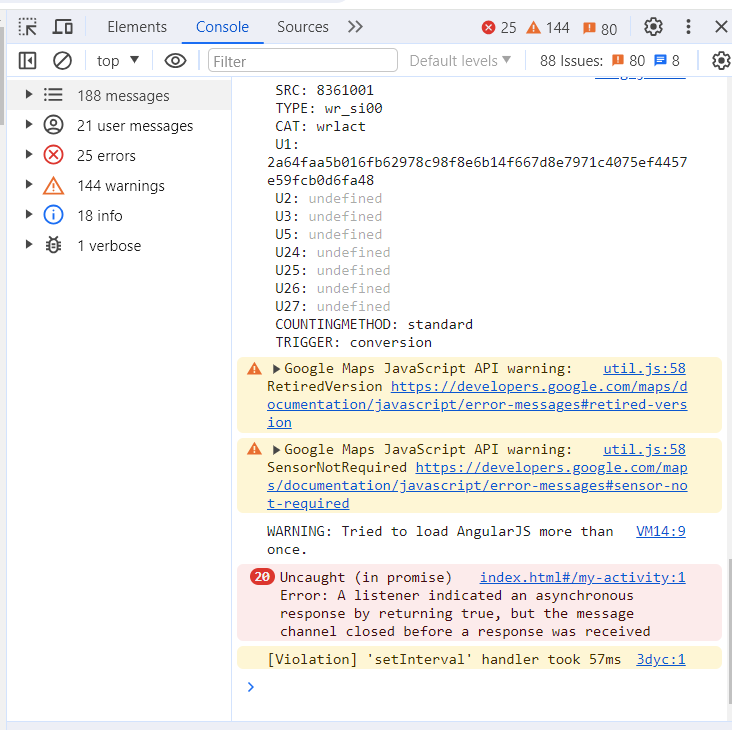

1. type in the console prompt (these are JavaScript commands):

&gt; `defaultClientId`

**the response will be a string which will be your client_id (normally 32-length string)**

2. type in the console prompt:

&gt; `JSON.parse(sessionStorage.getItem('authStatusData')).access_token`

**the response will be your access_token (normally 28-letter string)**

Insert them in the cell below

In [1]:
access_token = "l6qJDGuXdgzb7fkQL3Od6utfnbBN" # replace with yours!
# Note, that the access token will expire in 30 minutes, and you will need to get a new one with the JS string in the console I showed above 

client_id = "XXXXXXXXXXXXXXXXXXXXXXXX" # replace with yours!
# client_id will remain the same over time

In [2]:
# the activity feed, that provides the list of all transactions, work by pagination - you can request the second page using next page token from the first. 
# For the first page the token should be .. em.. FIRST_PAGE 
nextPageToken="FIRST_PAGE"
feed = []

In [6]:
while nextPageToken is not None:
    # when all the pages in the activity feed is exhausted, the nextPageToken will not be provided anymore by the endpoint, and the loop will stop
    print("Requesting page " + nextPageToken)

    payload = activity_query.replace("FIRST_PAGE", nextPageToken)

    headers = {
        'client_id': client_id,
        'authorization': "Bearer " + access_token,
        'Content-Type': 'application/json; charset=utf-8'
    } # minimal set of headers which does not cause 'unauthentificated/server-side' errors

    # send request to the endpoint: 
    response = rq.request("POST", graphql_url, data=payload, headers=headers)

    if response.status_code == 200:

        # responses from the endpoint are in JSON format and structured according to the graphQL query.
        response_json = response.json()

        # you can look and parse the JSON to understand what to do with it, but I have done it already - the real data is deeply nested, so I flatten it a bit:
        activity_feed_page = [r['items'] for r in response_json['data']['rtlRewardsActivityFeed']['list']['groups']]
        feed.extend(activity_feed_page)

        nextPageToken = response_json['data']['rtlRewardsActivityFeed']['list'].get('nextPageToken') # it's where the Nexp page token is
    else:
        print("Error: " + str(response.status_code))
        nextPageToken = None

Requesting page FIRST_PAGE


Requesting page eyJhbGciOiJSUzI1NiIsInR5cCI6IkpXVCIsImtpZCI6IjQ1NTI0NTI1YjE1MmQxMzZiYmMwYjc2ZCJ9.eyJuZXh0UGFnZVRva2VuIjoiZXlKaGJHY2lPaUpJVXpJMU5pSXNJblI1Y0NJNklrcFhWQ0o5LmV5SnNhVzFwZENJNk5UQXNJbTltWm5ObGRDSTZORGdzSW5kaGJHeGxkQ0k2SWpFeE16WTFPRGd5SWl3aWJHRnpkRkpsWTJWcGNIUkVZWFJsVkdsdFpTSTZJakl3TWpNdE1EZ3RNRFZVTVRjNk1UVTZORFlyTVRBNk1EQWlMQ0owZVhCbElqb2lRVXhNSWl3aVpuSnZiVVJoZEdVaU9pSXhPVGN3TFRBeExUQXhWREF3T2pBd09qQXdMakF3TUZvaUxDSjFiblJwYkVSaGRHVWlPaUl5TURJMExUQXhMVEV3VkRFeU9qRTRPalUxTGpZMk1sb2lMQ0pwWVhRaU9qRTNNRFE0T0RreE16WXNJbVY0Y0NJNk1UY3dORGc1TWpjek5uMC5iNXJ1dGZ2cjhhbWZGY2d2YTc2bHFFOFE0WVQxSHNBN0YybTRNbDY0Q2NvIiwic3JjIjoiUlRMIiwicnRsVHJhbnNhY3Rpb25Db3VudCI6NTAsImlhdCI6MTcwNDg4OTEzNn0.RxaqzweO1hUBm0zVbFE1yYyP7oDRxm52_pKwv5Y3nN9jVN07iTtSa-ooItftCs6bLg7lB04LXKB6yiRUzqHCgHDfPls387WAN-VCoXL-jUJMR4qeybaHptYAvktckC_jfX6NXkeGUGplOjHIP9OMjZ-s2PvrBzRtHdY94y0c2b5RuFSUIiAyDnpxN7vdcNqyOeagu92BBaiESm2kSV-pUW2QaaftDWWCsx2DyDGwW5j6rZaJF52CtwJhyWpwlrQipa76K3BD59HO_eSeUcfoXwGZ1s9UfgFSTceCFLytjmdjONi3CdT

In [7]:
# flatten the list of all transactions (some of them have a ereceipt, some of them have no ereceipt - i.e. fuel purchases)
transactions = [item for sublist in feed for item in sublist]

In [16]:
# Now for all transactions with a receipt (they have a 'receipt' key), we can get the receipt using the second graphQL query (from the same endpoint!) 

for i, transaction in enumerate(transactions):
    if transaction.get('receipt') is not None:

        # here's a bit of reverse-engineering magic: we need RECEIPT_ID for the graphQL query, but what is the way to compose it? Here:
        # first, 'receipt' field from the transaction object is JSON stringified (turn the dict into a string)
        receipt_data_stringified = json.dumps(transaction['receipt'])

        # then this string is base64 encoded
        encoded_rid = (base64.b64encode(receipt_data_stringified.encode("utf-8"))).decode() # decode to in the end is to get a proper string instead of a byte-string

        # Thit string is what we need for the query (insert it in place of the RECEIPT_ID placeholder):
        payload = receipt_query.replace("RECEIPT_ID", encoded_rid)

        # plus, same headers are needed with the credentials
        headers = {
            'client_id': client_id,
            'authorization': "Bearer " + access_token,
            'Content-Type': 'application/json; charset=utf-8'
        }

        # note POST method for the request
        response = rq.request("POST", graphql_url, data=payload, headers=headers)

        if response.status_code == 200:
            response_json = response.json()

            # append the ereceipt data into the same list/dict object we created before, under 'ereceipt' key 
            transactions[i]['ereceipt'] = response_json['data']
            print("Receipt received for transaction " + transaction['id'])
        else:
            print("Error reading the receipt: " + str(response.status_code))
    else:
        print("No receipt for transaction " + transaction['id'])

Receipt request for transaction 1628525550
Receipt received for transaction 1628525550
Receipt request for transaction 1622180592
Receipt received for transaction 1622180592
Receipt request for transaction 1619478892
Receipt received for transaction 1619478892
Receipt request for transaction 1613088160
Receipt received for transaction 1613088160
Receipt request for transaction 1610720249
Receipt received for transaction 1610720249
No receipt for transaction 1598023443
Receipt request for transaction 1597728332


Receipt received for transaction 1597728332
No receipt for transaction 1571971802
Receipt request for transaction 1571715257
Receipt received for transaction 1571715257
No receipt for transaction 1557405982
Receipt request for transaction 1557329948
Receipt received for transaction 1557329948
No receipt for transaction 1552564486
Receipt request for transaction 1552480817
Receipt received for transaction 1552480817
No receipt for transaction 1533438419
Receipt request for transaction 1533209554
Receipt received for transaction 1533209554
No receipt for transaction 1525660336
Receipt request for transaction 1525405487
Receipt received for transaction 1525405487
No receipt for transaction 1519010266
No receipt for transaction 1518248779
No receipt for transaction 1501700478
Receipt request for transaction 1501422110
Receipt received for transaction 1501422110
Receipt request for transaction 1491239727
Receipt received for transaction 1491239727
Receipt request for transaction U2FsdGVkX19

In [21]:
# Now in transactions list we have all the data we scraped in a complex tree-like structure. How to flatten it into a table is a different notebook.
# but, overall, look here:

# take one transaction to look into it:
transactions[0]

# this is transaction's summary:
transactions[0]['transaction']
# {'origin': 'Ashfield', 'amountAsDollars': '$90.86'} 

# this is its e-receipt:
transactions[0]['ereceipt']
# again, many nested dicts/list in there, but you will easily see all the items purchased.

# what is probably easiest way to deal with this file is, to write it into a file:
with open('transactions.json', 'w') as f:
    json.dump(transactions, f)

# and then ask chatGPT to turn it into a table - should work, why not, right?

So: you can scrape your ereceipts using basic python http requests in json format, and for that you will need:
1) endpoint address - which I gave you,
2) query formats for the endpoint - which I gave you,
3) headers and request parameters - which I gave you,
4) and obtain credentials in correct format for the request - and I explained you how you can do it!

Lood luck with your data!

Alternatively, you can go to [myshopdash.app](https://myshopdash.app), which is my service that implemets all this knowledge in a easy-to-use form, and also all the parsing is done for you, Coles is supported, and you can download all your data as CSV files!